In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp
import change_point_post_analysis as cppa
import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc
import tqdm
import misc

import switch_analysis_one_session as saos
reload(saos)

reload(misc)
import nmf_sweep_error as nse
from collections import OrderedDict

67 sessions!
67 sessions!
<module 'sys' (built-in)>


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/cosyne'

db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
data_dir_full = db_sorted['data_dir_full'][0]

In [254]:
sess_selected.groupby(level=0).count().median()

4.0

In [3]:
res_to_save_data_detection_l=pickle.load(open(os.path.join('/mnt/home/szheng/ceph/place_variability/data','switch_res_allromsess_highrepeats_swmag0dot4.p'),'rb'))
plt.close('all')
sess_selected = db_sorted.loc[db_sorted['n_pyr_putative'] >= 50,'sess_name']
switch_detection_res_allsess = cppa.reshape_switch_detection_result_all_sess(res_to_save_data_detection_l,sess_selected)

# switch_detection_res_allsess = saos.load_switch_analysis_res_allsess(save_fn_one='shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p'
#     ,force_reload=False,dosave=True,load_only=False,n_pyr_thresh=50)





/mnt/home/szheng/projects/nmf_analysis/change_point_post_analysis.py:37: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  switch_detection_res_allsess[detection][key] = switch_detection_res_allsess[detection][key].loc[(slice(None),sess_selected.values),:]
/mnt/home/szheng/projects/nmf_analysis/change_point_post_analysis.py:37: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  switch_detection_res_allsess[detection][key] = switch_detection_re

In [218]:
sw_res_one['avg']['changes_df']

0   1   2   3   4   5   6   7   8   9   \
0 0 raw switch_magnitude 0.4 3   0   0   1   0   0   0   0   0   0   0   0   
                             27  0   0   0   0   0   0   0   0   0   0   0   
                             29  0   0   0   0   0   0   1   0   0   0   0   
                                 1   0   0   1   0  -1   0   0   0   0   0   
                                 2   0   1   0   0   0   0   0   0   0   0   
...                                 ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
  1 0.3 switch_magnitude 0.4 468 0   0   0   0   0   0   0   0   1   0  -1   
                             474 0   0   0   0   0   0   0   0   0   0   0   
                                 1   0   0   0   0   0   0   0   0   0   0   
                             475 0   0   0   0   0   0   0   0   0   0   0   
                             476 0   0   0   0  -1   0   0   0   0   0   0   

                                    ...  27  28  29  30  31  32   33   34  \
0 0 raw switch_magnitude 0.4 3   0  ...   0   0   0   0   0   0  NaN  NaN   
                             27  0  ...   0   0   0   0   0   0  NaN  NaN   
                             29  0  ...   0   0   0   0   0   0  NaN  NaN   
                                 1  ...   0   0   0   0   0   0  NaN  NaN   
                                 2  ...   0   0   0   0   0   0  NaN  NaN   
...                                 ...  ..  ..  ..  ..  ..  ..  ...  ...   
  1 0.3 switch_magnitude 0.4 468 0  ...   0   0   0   0   0   0  0.0  0.0   
                             474 0  ...   0   0   0   0   0   0  0.0  0.0   
                                 1  ...   0   0   0   0   0   0  0.0  0.0   
                             475 0  ...   0   0   0   0   0   0  0.0  0.0   
                             476 0  ...   0   0   0   0   0   0  0.0  0.0   

                                     35   36  
0 0 raw switch_magnitude 0.4 3   0  NaN  NaN  
                             27  0  NaN  NaN  
                             29  0  NaN  NaN  
                                 1  NaN  NaN  
                                 2  NaN  NaN  
...                                 ...  ...  
  1 0.3 switch_magnitude 0.4 468 0  0.0  0.0  
                             474 0  0.0  0.0  
                                 1  0.0  0.0  
                             475 0  0.0  0.0  
                             476 0  0.0  0.0  

[1524 rows x 37 columns]

In [4]:
%%time
reload(pf)
place_field_res_l = OrderedDict()
for ii in tqdm.tqdm(range(len(db_sorted['data_dir_full']))):
    ddf = db_sorted['data_dir_full'][ii]
    pf_res =pf.field_detection_both_avg_trial_wrapper(ddf, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )
    ani = db_sorted.iloc[ii]['animal_name.1']
    sess = db_sorted.iloc[ii]['sess_name']
    place_field_res_l[ani,sess] = pf_res
    

  1%|▏         | 1/67 [00:00<00:20,  3.17it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


  6%|▌         | 4/67 [00:00<00:10,  5.73it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


  9%|▉         | 6/67 [00:00<00:08,  7.00it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 12%|█▏        | 8/67 [00:01<00:06,  9.43it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 16%|█▋        | 11/67 [00:01<00:08,  6.68it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210111/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 22%|██▏       | 15/67 [00:01<00:04, 11.13it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210203/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 25%|██▌       | 17/67 [00:02<00:04, 10.77it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211124/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210201/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 33%|███▎      | 22/67 [00:02<00:03, 14.53it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210331/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 39%|███▉      | 26/67 [00:02<00:03, 10.59it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 43%|████▎     | 29/67 [00:03<00:02, 12.76it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 51%|█████     | 34/67 [00:03<00:02, 15.20it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210315/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201002/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 57%|█████▋    | 38/67 [00:03<00:01, 19.97it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201004/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200716/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 61%|██████    | 41/67 [00:03<00:01, 18.03it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200920/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200723/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 66%|██████▌   | 44/67 [00:04<00:02,  9.92it/s]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201125/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201129/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200917/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 75%|███████▍  | 50/67 [00:04<00:01, 12.42it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200719/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 79%|███████▉  | 53/67 [00:04<00:00, 14.81it/s]

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


 87%|████████▋ | 58/67 [00:05<00:00, 17.11it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_201001/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200717/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


100%|██████████| 67/67 [00:05<00:00, 11.91it/s]

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200715/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201121/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200823/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200824/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
CPU times: user 1.14 s, sys: 202 ms, total: 1.34 s
Wall time: 5.64 s


In [ ]:
import pairwise_shareonoff_test as pst


In [3]:
%%time
reload(pf)
pst_res_l = OrderedDict()
pst_res_l_selected = OrderedDict()
for ii in tqdm.tqdm(range(len(db_sorted['data_dir_full']))):
    ddf = db_sorted['data_dir_full'][ii]
#     pf_res =pf.field_detection_both_avg_trial_wrapper(ddf, dosave=True,force_reload=False,nbins = 100, 
#                                         save_fn = 'place_field_avg_and_trial_vthresh.p', 
#                                         shuffle_fn='fr_map_null_trialtype_vthresh.p',
#                                         smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
#                                         )
    pst_res=pst.pairwise_shareonoff_test_one_session(ddf,pst.SW_RES_FN, save_fn=pst.SAVE_FN,dosave=False,force_reload=False,
                                        nrepeats=100,load_only=True
                                        )
    ani = db_sorted.iloc[ii]['animal_name.1']
    sess = db_sorted.iloc[ii]['sess_name']
    pst_res_l[ani,sess] = pst_res
    if pst_res is not None:
        pst_res_l_selected[ani,sess] = pst_res['avg'].loc[(slice(None),slice(None),0.3,'switch_magnitude',0.4),:]
    

67 sessions!


In [13]:
pst_res_l_selected_df = pd.concat(pst_res_l_selected,axis=0).droplevel((-1,-2,-3))

In [27]:
pst_res_l_selected_df['issig'].groupby(level=(0,1,2)).any().mean()

onoff             0.56
on                0.56
off               0.58
onoff_ratio_on    0.38
dtype: float64

In [34]:
frac_sig_sess_per_ani=pst_res_l_selected_df['issig'][['on','off']].groupby(level=(0,1,2)).any().groupby(level=0).mean()

,on,off
e13_16f1,0.777778,0.666667
e13_26m1,0.800000,0.600000
e14_2m3,0.000000,0.200000
e15_10m1,0.400000,0.400000
e15_13f1,0.750000,0.750000
e15_9f1,0.333333,0.833333
e16_1f1,0.500000,0.333333
e16_2m1,0.000000,0.500000
e16_3m1,0.750000,0.500000
e16_3m2,1.000000,1.000000


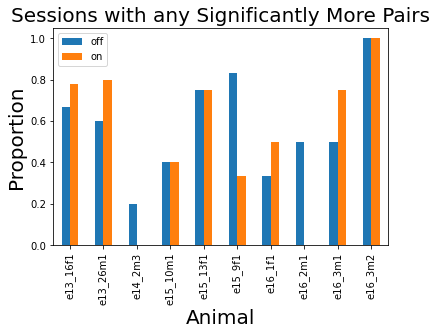

In [37]:
frac_sig_sess_per_ani=pst_res_l_selected_df['issig'][['off','on']].groupby(level=(0,1,2)).any().groupby(level=0).mean()
ax=frac_sig_sess_per_ani.plot.bar()
# legend = anysigsess.groupby(level=(0)).mean().columns.get_level_values(0).unique()
# ax.legend(legend)
ax.set(xlabel='Animal',title='Sessions with any Significantly More Pairs',ylabel='Proportion')
fig=ax.figure
fig.savefig(os.path.join(figdir,f'sess_with_sig_more_pair_per_ani.pdf'),bbox_inches='tight')

In [29]:
pst_res_l_selected_df

count                                   cdf  \
                             onoff      on    off onoff_ratio_on   onoff   
e13_26m1 e13_26m1_210913 0 0  54.0   918.0  671.0       0.058824  0.9956   
                           1  50.0  1053.0  810.0       0.047483  0.9965   
e15_13f1 e15_13f1_220117 0 0  77.0  1209.0  483.0       0.063689  0.9997   
                           1  21.0   686.0  376.0       0.030612  0.9506   
         e15_13f1_220118 0 0  50.0   637.0  448.0       0.078493  0.9997   
...                            ...     ...    ...            ...     ...   
e15_9f1  e15_9f1_200717  0 1   1.0    11.0   16.0       0.090909  0.9891   
         e15_9f1_200715  0 0   0.0    13.0    1.0            0.0  0.9273   
                           1   0.0    24.0   30.0            0.0   0.858   
e14_2m3  e14_2m3_201121  0 0   0.0    36.0    7.0            0.0  0.4439   
                           1   1.0    13.0   10.0       0.076923  0.8847   

                                                             issig         \
                                  on     off onoff_ratio_on  onoff     on   
e13_26m1 e13_26m1_210913 0 0     1.0     1.0         0.9099   True   True   
                           1     1.0     1.0          0.793   True   True   
e15_13f1 e15_13f1_220117 0 0     1.0   0.998         0.9803   True   True   
                           1     1.0  0.9995          0.733  False   True   
         e15_13f1_220118 0 0  0.9735  0.9687         0.9991   True  False   
...                              ...     ...            ...    ...    ...   
e15_9f1  e15_9f1_200717  0 1  0.5511  0.8441         0.8932   True  False   
         e15_9f1_200715  0 0  0.6935  0.7745         0.9273  False  False   
                           1  0.9954  0.9958          0.858  False   True   
e14_2m3  e14_2m3_201121  0 0  0.9537  0.3774         0.4439  False  False   
                           1  0.5705  0.9678         0.7081  False  False   

                                                    
                                off onoff_ratio_on  
e13_26m1 e13_26m1_210913 0 0   True          False  
                           1   True          False  
e15_13f1 e15_13f1_220117 0 0   True           True  
                           1   True          False  
         e15_13f1_220118 0 0  False           True  
...                             ...            ...  
e15_9f1  e15_9f1_200717  0 1  False          False  
         e15_9f1_200715  0 0  False          False  
                           1   True          False  
e14_2m3  e14_2m3_201121  0 0  False          False  
                           1  False          False  

[100 rows x 12 columns]

In [13]:
ani_sess = ('e13_26m1','e13_26m1_210913')
sw_ind = (0,0,0.3,'switch_magnitude',0.4)
changes_one = switch_detection_res_allsess['avg']['changes_df'].loc[(*ani_sess,*sw_ind),:].dropna(axis=1)

/tmp/ipykernel_74559/2221808589.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_one = switch_detection_res_allsess['avg']['changes_df'].loc[(*ani_sess,*sw_ind),:].dropna(axis=1)


In [151]:
def get_shared_onoff(changes_one):
    on = (changes_one == 1).astype(int)
    off = (changes_one == -1).astype(int)

    on_outer=np.einsum('ft,dt->fd',on, on)
    share_on_count = len(np.nonzero(np.triu(on_outer,1))[0])
    off_outer=np.einsum('ft,dt->fd',off, off)
    share_off_count = len(np.nonzero(np.triu(off_outer,1))[0])
    
    share_onoff=(on_outer>0) & (off_outer > 0)
    np.fill_diagonal(share_onoff,0)
    share_onoff = np.triu(share_onoff)

    share_onoff_inds = np.nonzero(share_onoff)
    share_onoff_count = len(share_onoff_inds[0])
    
    share_onoff_ratio_on = share_onoff_count / share_on_count

    return share_onoff_inds, share_onoff_count, share_on_count, share_off_count, share_onoff_ratio_on

In [191]:
def shuffle_test_pair_share_onoff(changes_one,nrepeats=100,alpha=0.025):
    changes_shuffle_l = cpa.gen_circular_shuffle(changes_one,nrepeats)
    
    
    
    share_onoff_count_l=[]
    share_on_count_l = []
    share_off_count_l = []
    share_onoff_ratio_on_l = []
    
    
    for changes_shuffle in changes_shuffle_l:
        _, share_onoff_count, share_on_count, share_off_count,share_onoff_ratio_on = get_shared_onoff(changes_shuffle)
        share_onoff_count_l.append(share_onoff_count)
        share_on_count_l.append(share_on_count)
        share_off_count_l.append(share_off_count)
        share_onoff_ratio_on_l.append(share_onoff_ratio_on)
    
    share_shuffle = {'onoff':np.array(share_onoff_count_l),'on':np.array(share_on_count_l),
                     'off':np.array(share_off_count_l),'onoff_ratio_on':np.array(share_onoff_ratio_on_l)}
    
    share_data = {}
    share_onoff_inds, share_data['onoff'], share_data['on'], share_data['off'],share_data['onoff_ratio_on'] = get_shared_onoff(changes_one)
    
    cdf_d = {}
    issig_d = {}
    for k,shuffle in share_shuffle.items():
        data = share_data[k]
        cdf = np.mean(data >= shuffle)
        issig = cdf > (1-alpha)
        cdf_d[k] = cdf
        issig_d[k] = issig
    res = {'count':share_data,'cdf':cdf_d,'issig':issig_d}
    res = pd.DataFrame(res)
    return res
        
        
    

In [199]:
changes_df_all_one_detect = switch_detection_res_allsess['avg']['changes_df'].loc[(slice(None),slice(None),slice(None),slice(None),*sw_ind[2:])]
changes_df_all_one_detect_gpb = changes_df_all_one_detect.groupby(level=(0,1,2,3))

In [206]:
from pandarallel import pandarallel

In [207]:
pandarallel.initialize()

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [209]:
%%time
# pair_share_test_all_sess = changes_df_all_one_detect_gpb.apply(lambda x:shuffle_test_pair_share_onoff(x.dropna(axis=1),nrepeats=2,alpha=0.025))
pair_share_test_all_sess = changes_df_all_one_detect_gpb.parallel_apply(lambda x:shuffle_test_pair_share_onoff(x.dropna(axis=1),nrepeats=10000,alpha=0.025))
pair_share_test_all_sess=pair_share_test_all_sess.unstack(level=-1)



Process ForkPoolWorker-61:
Process ForkPoolWorker-59:
Process ForkPoolWorker-60:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-48:
Process ForkPoolWorker-73:
Process ForkPoolWorker-78:
Process ForkPoolWorker-76:
Process ForkPoolWorker-82:
Process ForkPoolWorker-72:
Process ForkPoolWorker-74:
Process ForkPoolWorker-79:
Process ForkPoolWorker-75:
Process ForkPoolWorker-67:
Process ForkPoolWorker-44:
Process ForkPoolWorker-70:
Process ForkPoolWorker-81:
Process ForkPoolWorker-69:
Process ForkPoolWorker-52:
Process ForkPoolWorker-55:
Process ForkPoolWorker-53:
Process ForkPoolWorker-77:
Process ForkPoolWorker-51:
Process ForkPoolWorker-68:
Process ForkPoolWorker-50:
Process ForkPoolWorker-64:
Process ForkPoolWorker-45:
Process ForkPoolWorker-58:
Process ForkPoolWorker-46:
Process ForkPoolWorker-66:
Process ForkPoolWorker-54:
Process ForkPoolWorker-63:
Process ForkPoolWorker-56:
Process ForkPoolWorker-65:
Process ForkPoolWorker-43:
Traceback (most recent call 

In [210]:
pair_share_test_all_sess.to_pickle('/mnt/home/szheng/ceph/place_variability/data/pair_share_test.p')

In [187]:
def plot_shuffle_data_dist_with_thresh(shuffle,data,alpha=0.025,fig=None,ax=None):
    thresh=np.quantile(shuffle,(1-alpha))
    percentile = (1-alpha) * 100
    if ax is None:
        fig,ax=plt.subplots()
    ax.hist(shuffle,histtype='step')
    ax.axvline(data,label='data')
    ax.axvline(thresh,label=f'{percentile} percentile',linestyle=':')
    ax.legend()
    return fig,ax

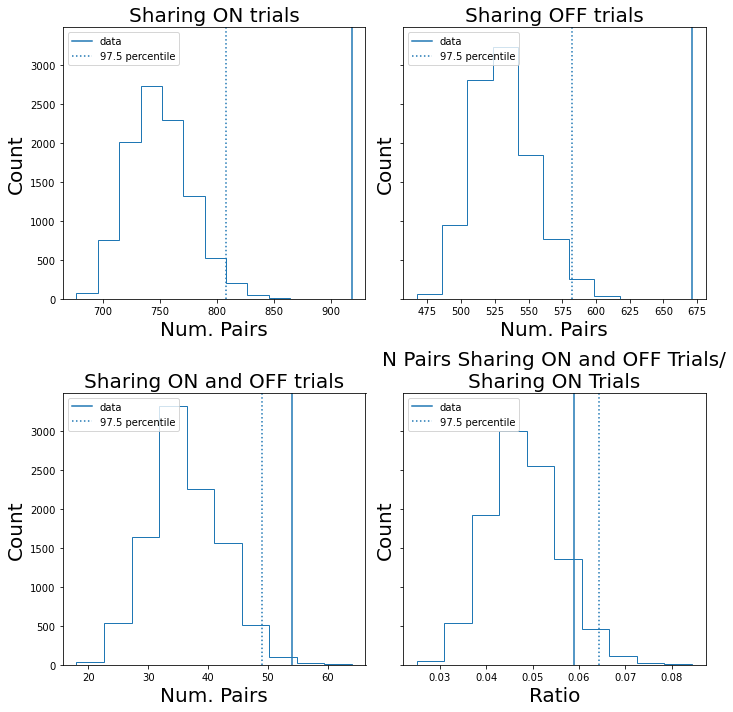

In [190]:
fig,axs = plt.subplots(2,2,sharey=True,figsize=(10,10))
fig,ax=plot_shuffle_data_dist_with_thresh(share_on_count_l,share_on_count,alpha=0.025,ax=axs[0,0])
_=ax.set(title='Sharing ON trials',xlabel='Num. Pairs', ylabel='Count')

fig,ax=plot_shuffle_data_dist_with_thresh(share_off_count_l,share_off_count,alpha=0.025,ax=axs[0,1])
_=ax.set(title='Sharing OFF trials',xlabel='Num. Pairs', ylabel='Count')

fig,ax=plot_shuffle_data_dist_with_thresh(share_onoff_count_l,share_onoff_count,alpha=0.025,ax=axs[1,0])
_=ax.set(title='Sharing ON and OFF trials',xlabel='Num. Pairs', ylabel='Count')

fig,ax=plot_shuffle_data_dist_with_thresh(share_onoff_ratio_on_l,share_onoff_ratio_on,alpha=0.025,ax=axs[1,1])
_=ax.set(title='N Pairs Sharing ON and OFF Trials/\nSharing ON Trials',xlabel='Ratio', ylabel='Count')
plt.tight_layout()

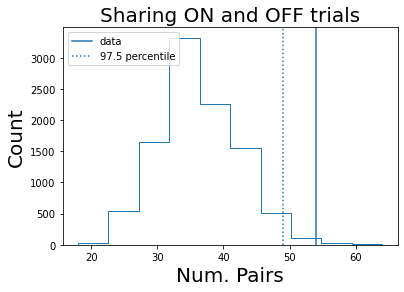

In [184]:
fig,ax=plot_shuffle_data_dist_with_thresh(share_onoff_count_l,share_onoff_count,alpha=0.025)
_=ax.set(title='Sharing ON and OFF trials',xlabel='Num. Pairs', ylabel='Count')

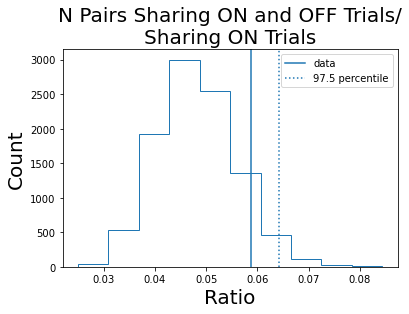

In [182]:
fig,ax=plot_shuffle_data_dist_with_thresh(share_onoff_ratio_on_l,share_onoff_ratio_on,alpha=0.025)
_=ax.set(title='N Pairs Sharing ON and OFF Trials/\nSharing ON Trials',xlabel='Ratio', ylabel='Count')

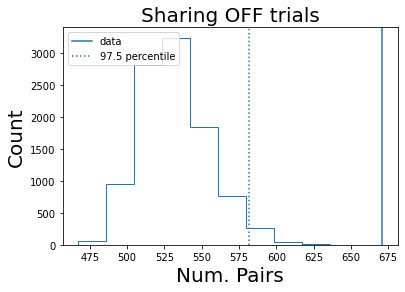

In [185]:
fig,ax=plot_shuffle_data_dist_with_thresh(share_off_count_l,share_off_count,alpha=0.025)
_=ax.set(title='Sharing OFF trials',xlabel='Num. Pairs', ylabel='Count')

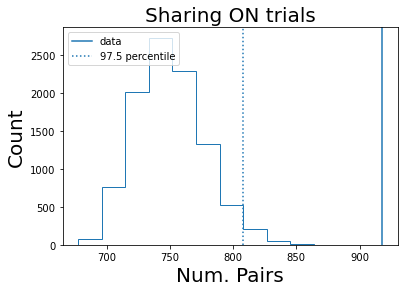

In [186]:
fig,ax=plot_shuffle_data_dist_with_thresh(share_on_count_l,share_on_count,alpha=0.025)
_=ax.set(title='Sharing ON trials',xlabel='Num. Pairs', ylabel='Count')

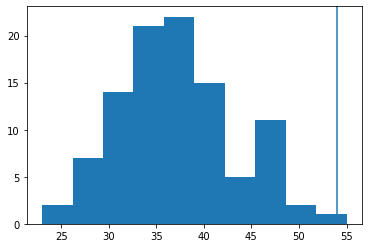

In [157]:
plt.hist(share_onoff_count_l)
plt.axvline(share_onoff_count)

In [130]:
interval_l=[]
for jj in range(len(ind1)):
    ind1,ind2=share_onoff_inds
    # jj=19
    i1 = changes_one.index[ind1[jj]]
    i2 = changes_one.index[ind2[jj]]

    switch_trials = changes_one.loc[[i1,i2]].all().to_numpy().nonzero()[0]
    interval = switch_trials[1] - switch_trials[0]
    interval_l.append(interval)

(array([48.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <BarContainer object of 10 artists>)

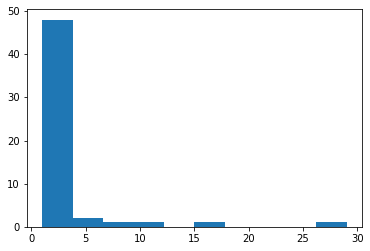

In [132]:
plt.hist(interval_l)

In [137]:
len(np.nonzero(np.triu(on_outer,1))[0])

918

In [105]:
place_field_res_l[ani_sess]['avg']['all_fields'][sw_ind[:2]].loc[[i1,i2]]

,,start,end,com,peak,fr_peak,fr_mean
,field_index,,,,,,
129,1,83,92,88,92,5.860195,4.608874
284,1,85,92,89,92,7.645683,5.709414
